<a href="https://colab.research.google.com/github/jjieun1212/basic_project/blob/main/ai_%EC%BD%94%EB%93%9C_%EC%B5%9C%EC%A2%85_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8(0611).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###tesseract-ocr 임포트


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,815 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

###사진 파일 업로드

In [ ]:
from google.colab import files
from PIL import Image

def upload_image():
    uploaded = files.upload()
    return uploaded

uploaded_files = upload_image()


Saving 1.jpg to 1.jpg


###사진에서 텍스트 출력

In [ ]:
import pytesseract

def extract_text_from_image(uploaded_files):
    for file_name in uploaded_files.keys():
        print(f"Processing file: {file_name}")
        image_path = file_name

        # 이미지를 열고 텍스트를 추출
        image = Image.open(image_path)
        text = pytesseract.image_to_string(image)

        return text

extracted_text = extract_text_from_image(uploaded_files)
print("Extracted Text:", extracted_text)


Processing file: 1.jpg
Extracted Text:    

Sample label for
Macaroni & Cheese

 

Nutrition Facts

‘Serving Size 1 cup (228g)
Servings Per Container 2

 

 

     

   

 

 

es
‘Amount Per Servs
'50_Calories from Fat 110
% Dally Value
Total Fat 129 10%
Saturated Fat 3g 15%
Trans Fat 39
tholestero! 10%
Sodium 470mg 20%
Total Carbohydrate 319 10%
ietary Fiber Og o%
_ Sugars 5g
Protein 5g
|
MiaminA
Vitamin C 2%
Calcium 20%
tron 4%

* Percent Dally Values are based on a 2000 calorie cet.
‘Your Daly Values may be higher or lower depencing on

 

 

yur calorie needs.
Calories 2,000 2,500
‘Total Fat ‘Less than 659 809
Sat Fat Less than 20g 259
Cholesterol Less than 200mg 300mg
‘Sodium Less than 2,400mg  2,400mg|
Total Carbohydrate 300g (3759
Dietary Fiber 259 309

 

  

TE mcs

 



###텍스트 공백 정리

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # 여러 개의 공백을 하나로
    text = re.sub(r'[^\w\s\.\%]', '', text)  # 문자, 숫자, 공백, %를 제외한 모든 문자 제거
    return text

cleaned_text = clean_text(extracted_text)


###영양성분 maping
9,g 틀리는 문제 해결

In [ ]:
def extract_nutrition_facts(text):
    nutrition_facts = {}

    pattern = r'(?P<name>[A-Za-z\s]+)\s*(?P<value>\d+\.?\d*)\s*(?P<unit>[a-zA-Z%]+)'

    matches = re.finditer(pattern, text)

    for match in matches:
        name = match.group('name').strip()
        value = match.group('value').strip()
        unit = match.group('unit').strip()
        nutrition_facts[name] = {'value': value, 'unit': unit}

        # Check if unit length is 3 or more and value ends with 9
        if len(unit) >= 3 and value.endswith('9'):
            value = value[:-1]  # Remove the last '9'
            unit = 'g'  # Change unit to 'g'

        nutrition_facts[name] = {'value': value, 'unit': unit}

    return nutrition_facts

nutrition_facts = extract_nutrition_facts(cleaned_text)


###주요 성분 위주로 저장, 데이터셋과 동일한 형태로 정리

In [ ]:
import json

def format_to_ground_truth(nutrition_facts):
    ground_truth = {
        "gt_parse": {
            "serving": [],
            "cal": {},
            "fat": {},
            "cholesterol": {},
            "carb": {},
            "protein": {}
        }
    }

    # serving size와 per container 정보 찾기
    if "Serving Size" in nutrition_facts:
        serving_size = nutrition_facts.pop("Serving Size")
        ground_truth["gt_parse"]["serving"].append({
            "serving_size": serving_size['value'],
            "unit": serving_size['unit'],
            "gram": ""  # gram 정보가 없는 경우 빈 문자열
        })
    if "Servings Per Container" in nutrition_facts:
        servings_per_container = nutrition_facts.pop("Servings Per Container")
        ground_truth["gt_parse"]["serving"].append({
            "serving_size_per_contain": servings_per_container['value']
        })

    # calories 정보 찾기
    if "Calories" in nutrition_facts:
        calories = nutrition_facts.pop("Calories")
        if calories['value']:  # 값이 있는 경우에만 출력
            ground_truth["gt_parse"]["cal"]["calories"] = calories['value'] + calories['unit']

    # fat 정보 찾기
    fat_keys = ["Total Fat", "Saturated Fat", "Trans Fat"]
    for key in fat_keys:
        if key in nutrition_facts:
            fat_value = nutrition_facts.pop(key)
            if fat_value['value']:  # 값이 있는 경우에만 출력
                ground_truth["gt_parse"]["fat"][key.lower().replace(' ', '_')] = fat_value['value'] + fat_value['unit']

    # cholesterol 정보 찾기
    if "Cholesterol" in nutrition_facts:
        cholesterol = nutrition_facts.pop("Cholesterol")
        if cholesterol['value']:  # 값이 있는 경우에만 출력
            ground_truth["gt_parse"]["cholesterol"]["total_cholesterol"] = cholesterol['value'] + cholesterol['unit']
        else:
            del ground_truth["gt_parse"]["cholesterol"]  # 값이 없는 경우 항목 삭제

    # carbohydrate 정보 찾기
    carb_keys = ["Total Carbohydrate", "Dietary Fiber", "Sugars"]
    for key in carb_keys:
        if key in nutrition_facts:
            carb_value = nutrition_facts.pop(key)
            if carb_value['value']:  # 값이 있는 경우에만 출력
                ground_truth["gt_parse"]["carb"][key.lower().replace(' ', '_')] = carb_value['value'] + carb_value['unit']

    # protein 정보 찾기
    if "Protein" in nutrition_facts:
        protein = nutrition_facts.pop("Protein")
        if protein['value']:  # 값이 있는 경우에만 출력
            ground_truth["gt_parse"]["protein"]["total_protein"] = protein['value'] + protein['unit']

    return ground_truth

ground_truth = format_to_ground_truth(nutrition_facts)

# 출력된 결과에서 값이 없는 항목 삭제
for key in list(ground_truth["gt_parse"].keys()):
    if not ground_truth["gt_parse"][key]:  # 값이 없는 경우
        del ground_truth["gt_parse"][key]  # 해당 항목 삭제

# 추출된 결과 출력
ground_truth_json = json.dumps({"ground_truth": ground_truth}, separators=(',', ':'))
print(ground_truth_json)


{"ground_truth":{"gt_parse":{"serving":[{"serving_size_per_contain":"2"}],"fat":{"saturated_fat":"3g","trans_fat":"3g"},"carb":{"total_carbohydrate":"300g","sugars":"5g"},"protein":{"total_protein":"5g"}}}}


In [ ]:
import re

def clean_text(text):
    # 공백 및 특수 문자 정리
    text = re.sub(r'\s+', ' ', text)  # 여러 개의 공백을 하나로
    text = re.sub(r'[^\w\s\.\%]', '', text)  # 문자, 숫자, 공백, %를 제외한 모든 문자 제거
    return text

def extract_sugar_content(text):
    # 정규표현식을 이용해 Sugars 항목 추출
    pattern = r'Sugars\s*(\d+\.?\d*)\s*([a-zA-Z%]+)'

    match = re.search(pattern, text)

    if match:
        value = match.group(1).strip()
        unit = match.group(2).strip()
        return {'sugar': {'value': value, 'unit': unit}}
    else:
        return {}

# 텍스트 정제 및 Sugars 항목 추출 호출
cleaned_text = clean_text(extracted_text)
sugar_content = extract_sugar_content(cleaned_text)

# 추출된 결과 출력
if sugar_content:
    print("Sugars Content:")
    for nutrient, info in sugar_content.items():
        print(f"{nutrient}: {info['value']} {info['unit']}")
else:
    print("No Sugars content found.")


Sugars Content:
sugar: 5 g


###섭취 가능한 당분 계산, 해당 식품 섭취 가능 여부

In [ ]:
import re
import json

# get_sugar_value 함수
def get_sugar_value(parsed_data):
    sugar_info = parsed_data.get("gt_parse", {}).get("carb", {}).get("sugars")
    if sugar_info:
        value, unit = re.match(r'(\d+\.?\d*)([a-zA-Z%]+)', sugar_info).groups()
        return float(value), unit
    else:
        return None, None

# 사용자로부터 몸무게 입력 받기
weight = float(input("몸무게를 입력하세요 (kg): "))

# 하루 섭취 가능 칼로리 계산
calorie = weight * 24 * 1.5
print(f"하루 섭취 가능 칼로리: {calorie} kcal")

# 일일 섭취 가능 당류 계산 (당뇨 환자 기준)
sugar = calorie * 0.1 / 4
print(f"일일 섭취 가능 당류: {sugar} g")

# 당류 정보 추출
value, unit = get_sugar_value(ground_truth)

# 섭취 가능 여부 확인
if value is not None and unit is not None:
    if unit == '%':
        sugar_per = calorie * 0.1
        if value < sugar_per:
            print(f"앞으로 {sugar_per - value}mg 섭취 가능합니다.")
        else:
            print("섭취 불가능")
    elif unit == 'mg':
        sugar_mg = sugar * 1000
        if value < sugar_mg:
            print("섭취 가능")
            print(f"앞으로 {sugar_mg - value}mg 섭취 가능합니다.")
        else:
            print("섭취 불가능")
    else:
        if value < sugar:
            print("섭취 가능")
            print(f"앞으로 {sugar - value}g 섭취 가능합니다.")
        else:
            print("섭취 불가능")
else:
    print("당류 정보가 없습니다.")


몸무게를 입력하세요 (kg): 30
하루 섭취 가능 칼로리: 1080.0 kcal
일일 섭취 가능 당류: 27.0 g
섭취 가능
앞으로 22.0g 섭취 가능합니다.


###dataset install

In [ ]:
!pip install datasets

###허깅페이스 임포트, 데이터셋 저장

In [ ]:
# 허깅페이스 읽어오기
from datasets import load_dataset
# 'fruk19/nutrition_fact_donut_v1' 데이터셋 불러오기
dataset = load_dataset("fruk19/nutrition_fact_donut_v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})


###필요한 시스템 임포트

('{"gt_parse": {"serving": [{"serving_size": "503", "unit": "packages", '
 '"gram": "0g"}, {"serving_size_per_contain": "10"}], "cal": {"calories": '
 '"908"}, "fat": {"total_fat": "78g", "saturated_fat": "40.5g"}, "sodium": '
 '{"total_sodium": "517mg"}, "carb": {"total_carbohydrate": "10g", '
 '"dietary_fiber": "48g", "sugar": "23g", "sugars_add": "32g"}, "protien": '
 '{"total_protien": "12g"}}}')


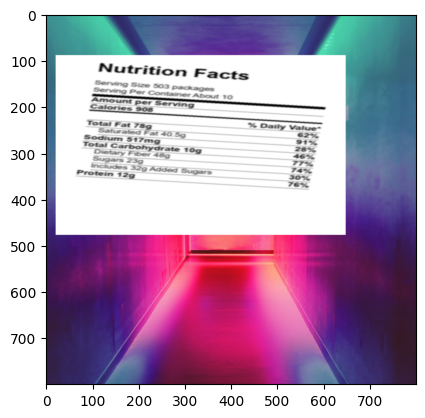

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
plt.imshow(dataset['test']['image'][1])
pprint(dataset['test']['ground_truth'][1])


###테스트를 위한 설탕 추출 메소드

In [ ]:
import json

def get_sugar_value(json_data):
    # Parse the JSON data
    parsed_data = json.loads(json_data)

    # Extract the value of sugar
    sugar_value = parsed_data.get("gt_parse", {}).get("carb", {}).get("sugar")

    # Return the sugar value or a not found message
    if sugar_value:
        return f"Sugar: {sugar_value}"
    else:
        return "Sugar information not found"

# Example usage
data = dataset['test']['ground_truth'][1]
print(get_sugar_value(data))

Sugar: 23g


###허깅페이스 데이터셋을 이용한 검증셋 생성

In [ ]:

from datasets import load_dataset
import json

true_arr = np.zeros(100)

# Load the dataset
dataset = load_dataset("fruk19/nutrition_fact_donut_v1")

def extract_and_print_sugar(dataset):
    """
    Iterate through the test set of the dataset and print the value of sugar from ground_truth with the index.

    Parameters:
    dataset (DatasetDict): A DatasetDict object with train, validation, and test sets.

    Returns:
    None
    """
    test_set = dataset['test']

    for index, entry in enumerate(test_set):
        # Parse the JSON data for each entry
        ground_truth = entry['ground_truth']
        parsed_data = json.loads(ground_truth)

        # Extract the value of sugar
        sugar_value = parsed_data.get("gt_parse", {}).get("carb", {}).get("sugar")

        # Print the sugar value or a not found message
        if sugar_value:
            print(f"Index {index}: Sugar: {sugar_value}")
        else:
            print(f"Index {index}: Sugar information not found")

        #당류 계산하고 섭취 가능하면 1 아니면 0으로 배열에 넣기
        if sugar_value:
            sugar_numeric = float(''.join(filter(str.isdigit, sugar_value)))
            if(sugar>sugar_numeric):
                true_arr[index] = 1
            else:
                true_arr[index] = 0
        else:
            true_arr[index] = 1

extract_and_print_sugar(dataset)
print(true_arr)

Index 0: Sugar information not found
Index 1: Sugar: 23g


NameError: name 'sugar' is not defined

###예측셋 배열 만들기

In [ ]:
pred_arr = np.zeros(100)
test_set = dataset['test']

#예측셋용 텍스트 추출 함수
def extract_text_from_image_pred(image_data):
    if isinstance(image_data, str):
        print(f"Processing file: {image_data}")
        image = Image.open(image_data)
    else:
        image = image_data

    text = pytesseract.image_to_string(image)
    return text


for index, entry in enumerate(test_set):


        #테스트셋 이미지에서 텍스트 추출
        image_data = dataset['test']['image'][1]
        extracted_text = extract_text_from_image_pred(image_data)
        # 텍스트 정제 및 영양 성분 추출 호출
        cleaned_text = clean_text(extracted_text)
        nutrition_facts = extract_nutrition_facts(cleaned_text)

        # gt_parse 형식으로 변환
        ground_truth = format_to_ground_truth(nutrition_facts)

        # 출력된 결과에서 값이 없는 항목 삭제
        for key in list(ground_truth["gt_parse"].keys()):
            if not ground_truth["gt_parse"][key]:  # 값이 없는 경우
                del ground_truth["gt_parse"][key]  # 해당 항목 삭제

        parsed_data = ground_truth

        # Extract the value of sugar
        sugar_value = parsed_data.get("gt_parse", {}).get("carb", {}).get("sugar")

        # Print the sugar value or a not found message
        if sugar_value:
            print(f"Index {index}: Sugar: {sugar_value}")
        else:
            print(f"Index {index}: Sugar information not found")

        #당류 계산하고 섭취 가능하면 1 아니면 0으로 배열에 넣기
        if sugar_value:
            sugar_numeric = float(''.join(filter(str.isdigit, sugar_value)))
            if(sugar>sugar_numeric):
                pred_arr[index] = 1
            else:
                pred_arr[index] = 0
        else:
            pred_arr[index] = 1





# Call the function
print(pred_arr)

Index 0: Sugar information not found
Index 1: Sugar information not found
Index 2: Sugar information not found
Index 3: Sugar information not found
Index 4: Sugar information not found
Index 5: Sugar information not found
Index 6: Sugar information not found
Index 7: Sugar information not found
Index 8: Sugar information not found
Index 9: Sugar information not found
Index 10: Sugar information not found
Index 11: Sugar information not found
Index 12: Sugar information not found
Index 13: Sugar information not found
Index 14: Sugar information not found
Index 15: Sugar information not found
Index 16: Sugar information not found
Index 17: Sugar information not found
Index 18: Sugar information not found
Index 19: Sugar information not found
Index 20: Sugar information not found
Index 21: Sugar information not found
Index 22: Sugar information not found
Index 23: Sugar information not found
Index 24: Sugar information not found
Index 25: Sugar information not found
Index 26: Sugar inform

###최종 평가
정확도, 민감도, 특이도,  정밀도, F1score 사용

In [ ]:
#라이브러리 import
!pip install pandas scikit-learn

import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix

#임시 데이터셋
y_true = true_arr # 실제 값 #true_arr 넣기


y_pred = pred_arr # 예측 값

# 정확도 계산
accuracy = accuracy_score(y_true, y_pred)

# 민감성(재현율) 계산
recall = recall_score(y_true, y_pred)

# F1 스코어 계산
f1 = f1_score(y_true, y_pred)

# 정밀도 계산
precision = precision_score(y_true, y_pred)

# 혼동 행렬 계산 (특이도 계산에 필요)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# 특이도 계산
specificity = tn / (tn + fp)

# 결과를 데이터프레임으로 정리
results = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'Precision', 'F1 Score'],
    'Score': [accuracy, recall, specificity, precision, f1]
})

print(results)

                 Metric     Score
0              Accuracy  0.650000
1  Sensitivity (Recall)  1.000000
2           Specificity  0.000000
3             Precision  0.650000
4              F1 Score  0.787879
